In [ ]:
!pip install plotly --upgrade

     |████████████████████████████████| 13.2MB 329kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
!pip install -U kaleido

     |████████████████████████████████| 74.6MB 54kB/s 


In [ ]:
import requests
from IPython.core.display import HTML

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import datetime
import matplotlib.pyplot as plt
%matplotlib inline


from urllib.request import urlopen
import json

import plotly
from urllib.request import urlopen

from plotly.figure_factory._county_choropleth import create_choropleth
import plotly.express as px
from plotly.subplots import make_subplots

from plotly.offline import download_plotlyjs, plot,iplot
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib import dates as mdates
import kaleido

In [ ]:
# You may need to define your path accordingly
path = ""

In [ ]:
# from google.colab import drive 
# drive.mount('/content/drive',force_remount=True)
# path = "/content/drive/MyDrive/Project-209a/"

Mounted at /content/drive


# 1. COVID cases

In [ ]:
# load counties
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

# Load population data
population = pd.read_csv(path + "data/covid_cases/covid_county_population_usafacts.csv")
population = population[(population['countyFIPS'] != 0) & (population['countyFIPS'] != 6000)]
population['fip'] = population['countyFIPS'].apply(lambda x: str(x).zfill(5))
population['population_draw'] = population['population']/10000
population.head()

,countyFIPS,County Name,State,population,fip,population_draw
1,1001,Autauga County,AL,55869,01001,5.5869
2,1003,Baldwin County,AL,223234,01003,22.3234
3,1005,Barbour County,AL,24686,01005,2.4686
4,1007,Bibb County,AL,22394,01007,2.2394
5,1009,Blount County,AL,57826,01009,5.7826


In [ ]:
# population data visualization
fig = px.choropleth(population, 
                    geojson=counties, 
                    locations='fip', color='population_draw',
                           #color_continuous_scale="Viridis",
                           range_color=(0, 50),
                           scope="usa",
                          )
fig.update_layout(title_text = 'population', title_x=0.5,title_font_size = 20)


fig.write_image(path+'graphs/population.png',  format = "png", scale=2, engine="kaleido")


In [ ]:
# load case data
case = pd.read_csv(path+"data/covid_cases/covid_confirmed_usafacts_new.csv")
case['fip'] = case['countyFIPS'].apply(lambda x: str(x).zfill(5))
case.head(1)

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,fip
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,00000


In [ ]:
# case data preprocessing
month_3 = case.columns.get_loc("3/1/20")
month_4 = case.columns.get_loc("4/1/20")
month_5 = case.columns.get_loc("5/1/20")
month_6 = case.columns.get_loc("6/1/20")
month_7 = case.columns.get_loc("7/1/20")
month_8 = case.columns.get_loc("8/1/20")
month_9 = case.columns.get_loc("9/1/20")
case['March'] = case.iloc[:,month_3:month_4].mean(axis=1)
case['April'] = case.iloc[:,month_4:month_5].mean(axis=1)
case['May'] = case.iloc[:,month_5:month_6].mean(axis=1)
case['June'] = case.iloc[:,month_6:month_7].mean(axis=1)
case['July'] = case.iloc[:,month_7:month_8].mean(axis=1)
case['August'] = case.iloc[:,month_8:month_9].mean(axis=1)
case.head(1)

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,fip,March,April,May,June,July,August
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,00000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Visualize confirmed cases in different months
months = ['March', 'April', 'May','June', 'July', 'August']
for month in months:
    fig = px.choropleth(case, 
                        geojson=counties, 
                        locations='fip', color=month,
                               #color_continuous_scale="Viridis",
                               range_color=(0, 50),
                               scope="usa",
                               labels={'confirmed cases':month}
                              )
    fig.update_layout(title_text = 'confirmed cases in %s'%(month), ) #margin={"r":0,"t":0,"l":0,"b":0}
    fig.write_image(path+'graphs/confirmed_cases_%s.png'%(month),  format = "png", scale=2, engine="kaleido")


In [ ]:
# Clear data, transform date string to datetime

case_state = case.drop(['March', 'April', 'May','June', 'July', 'August', 'countyFIPS', 'County Name'], axis = 1).groupby(by = 'State').sum()
case_state_num = case_state.drop('stateFIPS', axis = 1)
case_state_date = list(case_state.columns)
case_state_date.pop(0)
case_state_date = list(map(datetime.datetime.strptime, case_state_date, len(case_state_date)*['%m/%d/%y']))
case_state_name = list(case_state.index)

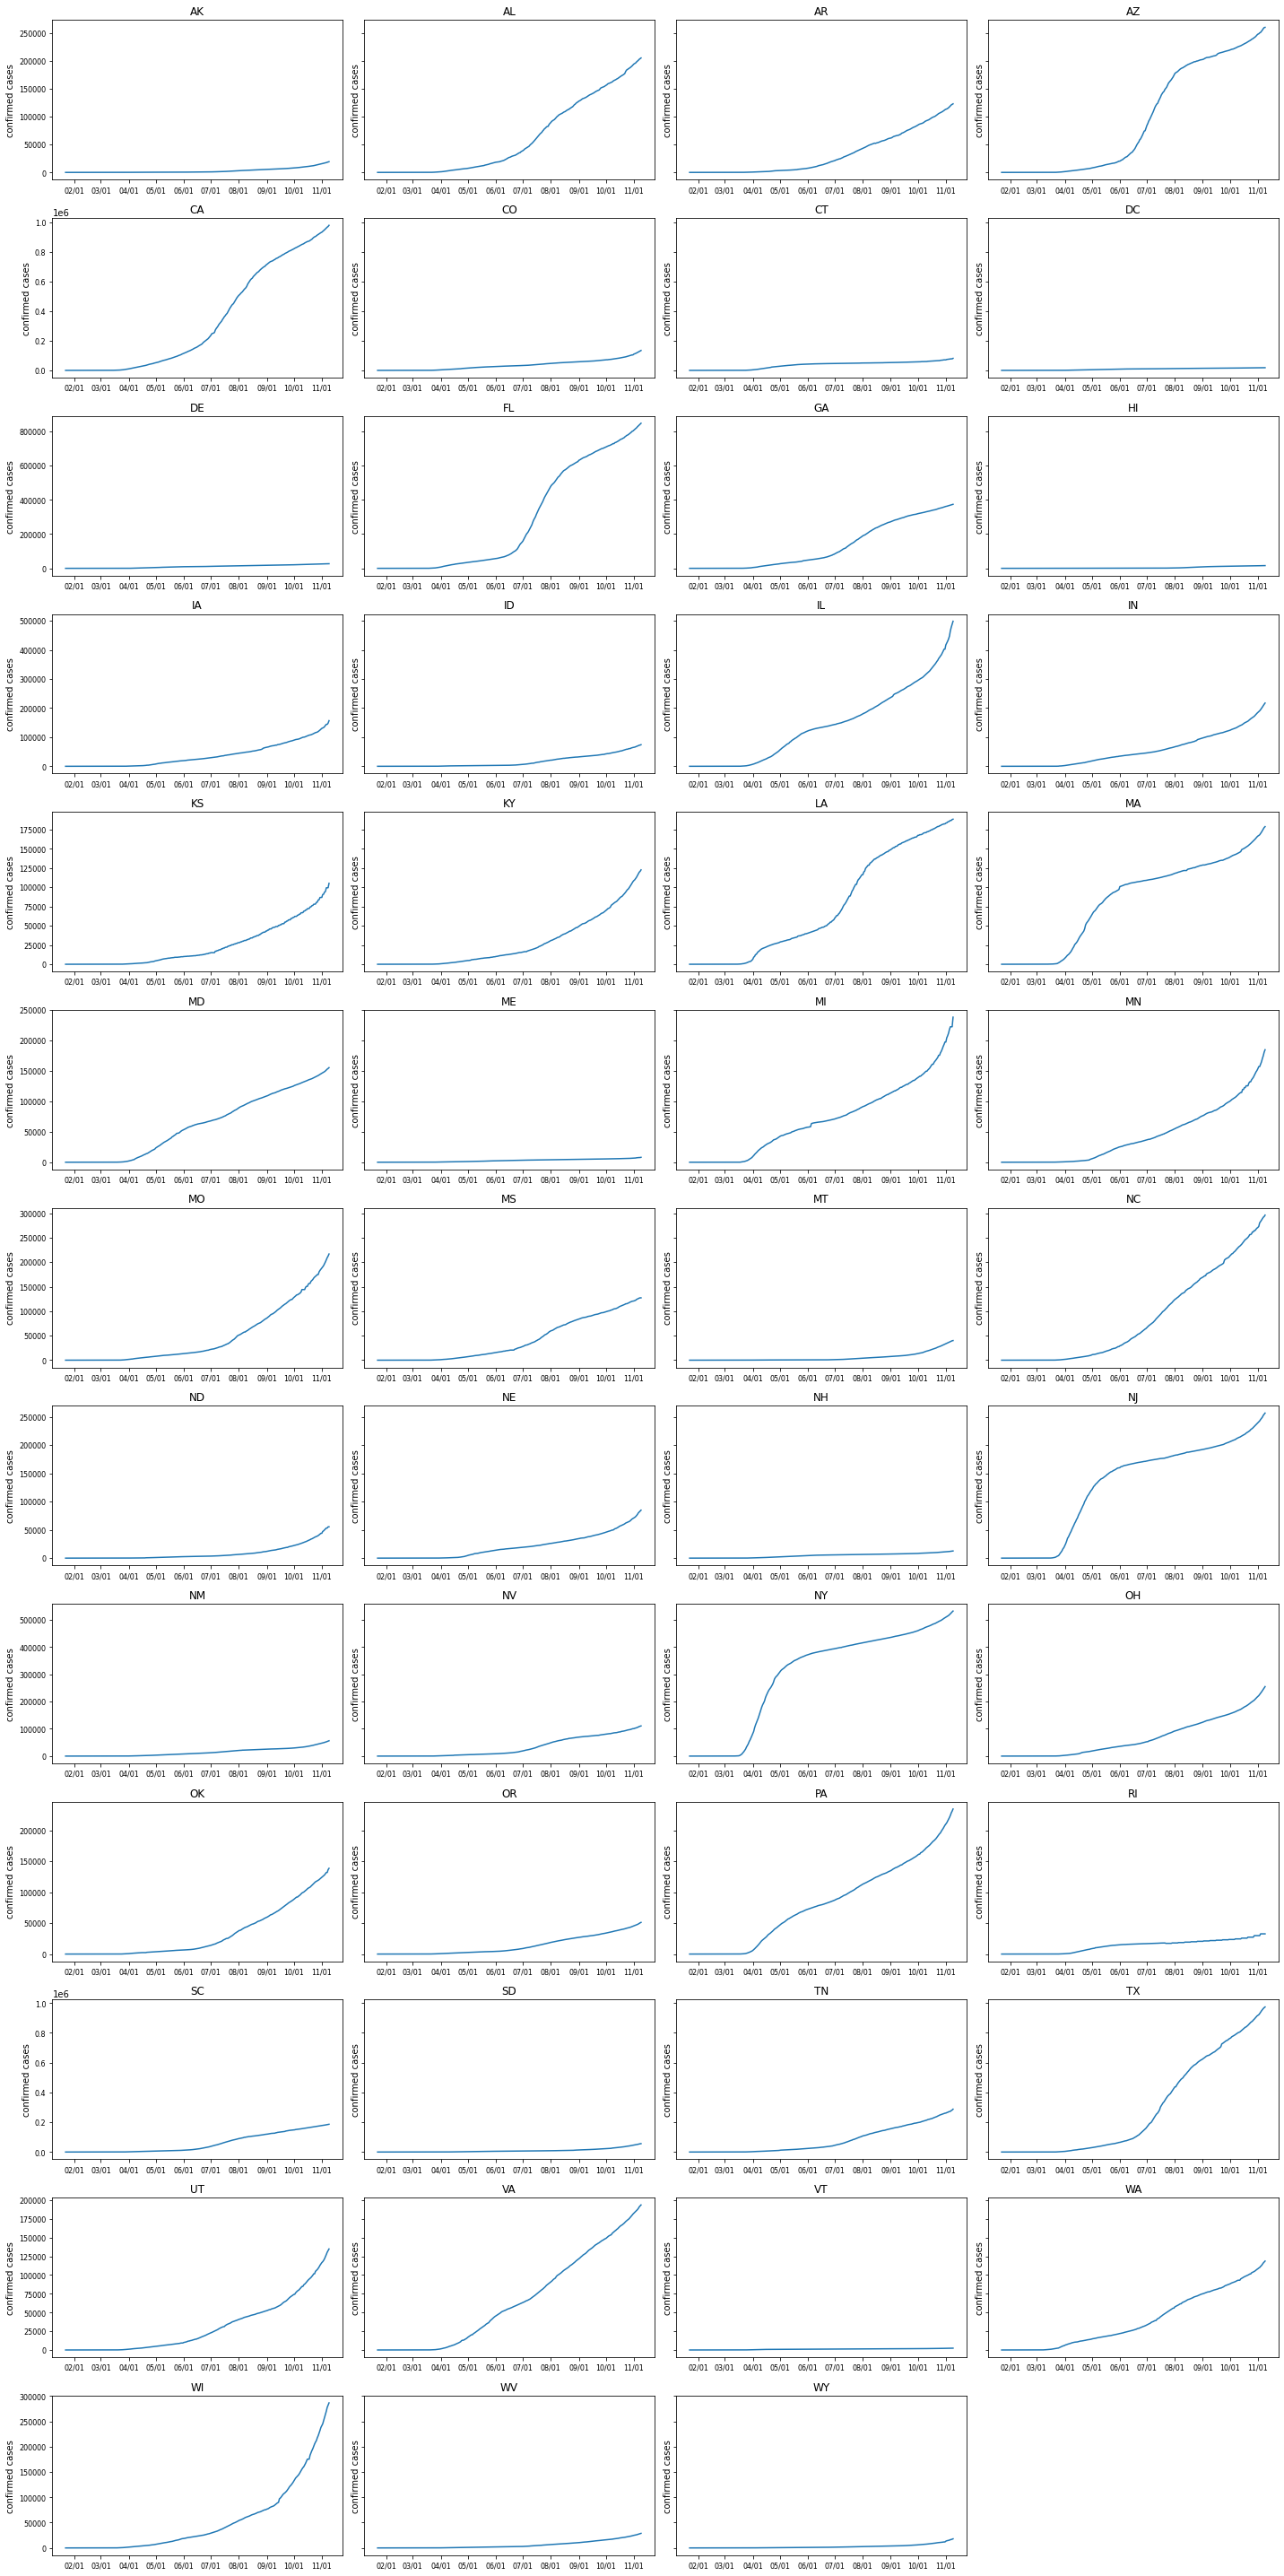

In [ ]:
# Time-series visualization for the US and each state

fig, axs = plt.subplots(13, 4, figsize = (20,40),sharey='row')
i = 0

for ax in axs.ravel()[0:51]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_title("%s"%(str(case_state_name[i])))

    ax.plot(case_state_date, case_state_num.iloc[i,:])
    
    ax.set_ylabel("confirmed cases")
      
    i += 1
    

fig.delaxes(axs[12,3])
plt.tight_layout()
fig.savefig(path+"graphs/confirmed cases.png")

# 2. Social Distance Data

In [ ]:
# Import social distance data

sd_data_folder_path = path+'data/distance_data/'
data_names = ["national_2019", "state_2019", "county_2019",
             "national_2020", "state_2020", "county_2020"]
data_all = {}
for data_name in data_names:
    data = pd.read_csv(sd_data_folder_path+"%s.csv"%(data_name))
    
    data_all[data_name] = data
    print(data_name, data.shape)

national_2019 (304, 24)
state_2019 (15504, 24)
county_2019 (955168, 24)
national_2020 (305, 24)
state_2020 (15555, 24)
county_2020 (968330, 24)


In [ ]:
# To compare 2019 and 2020, we need to drop Feb 29, 2020
visual_data = {}
for data_name in data_names:
    df = data_all[data_name]
    df = df[df["only_date"]!="02/29"]
    
    visual_data[data_name] = df
    print(data_name, df.shape)

national_2019 (304, 24)
state_2019 (15504, 24)
county_2019 (955168, 24)
national_2020 (304, 24)
state_2020 (15504, 24)
county_2020 (965188, 24)


In [ ]:
# Choose dataset for time-series visualization

cur_state = visual_data["state_2020"]
prev_state = visual_data["state_2019"]

state_names = visual_data["state_2020"]["state_code"].unique()

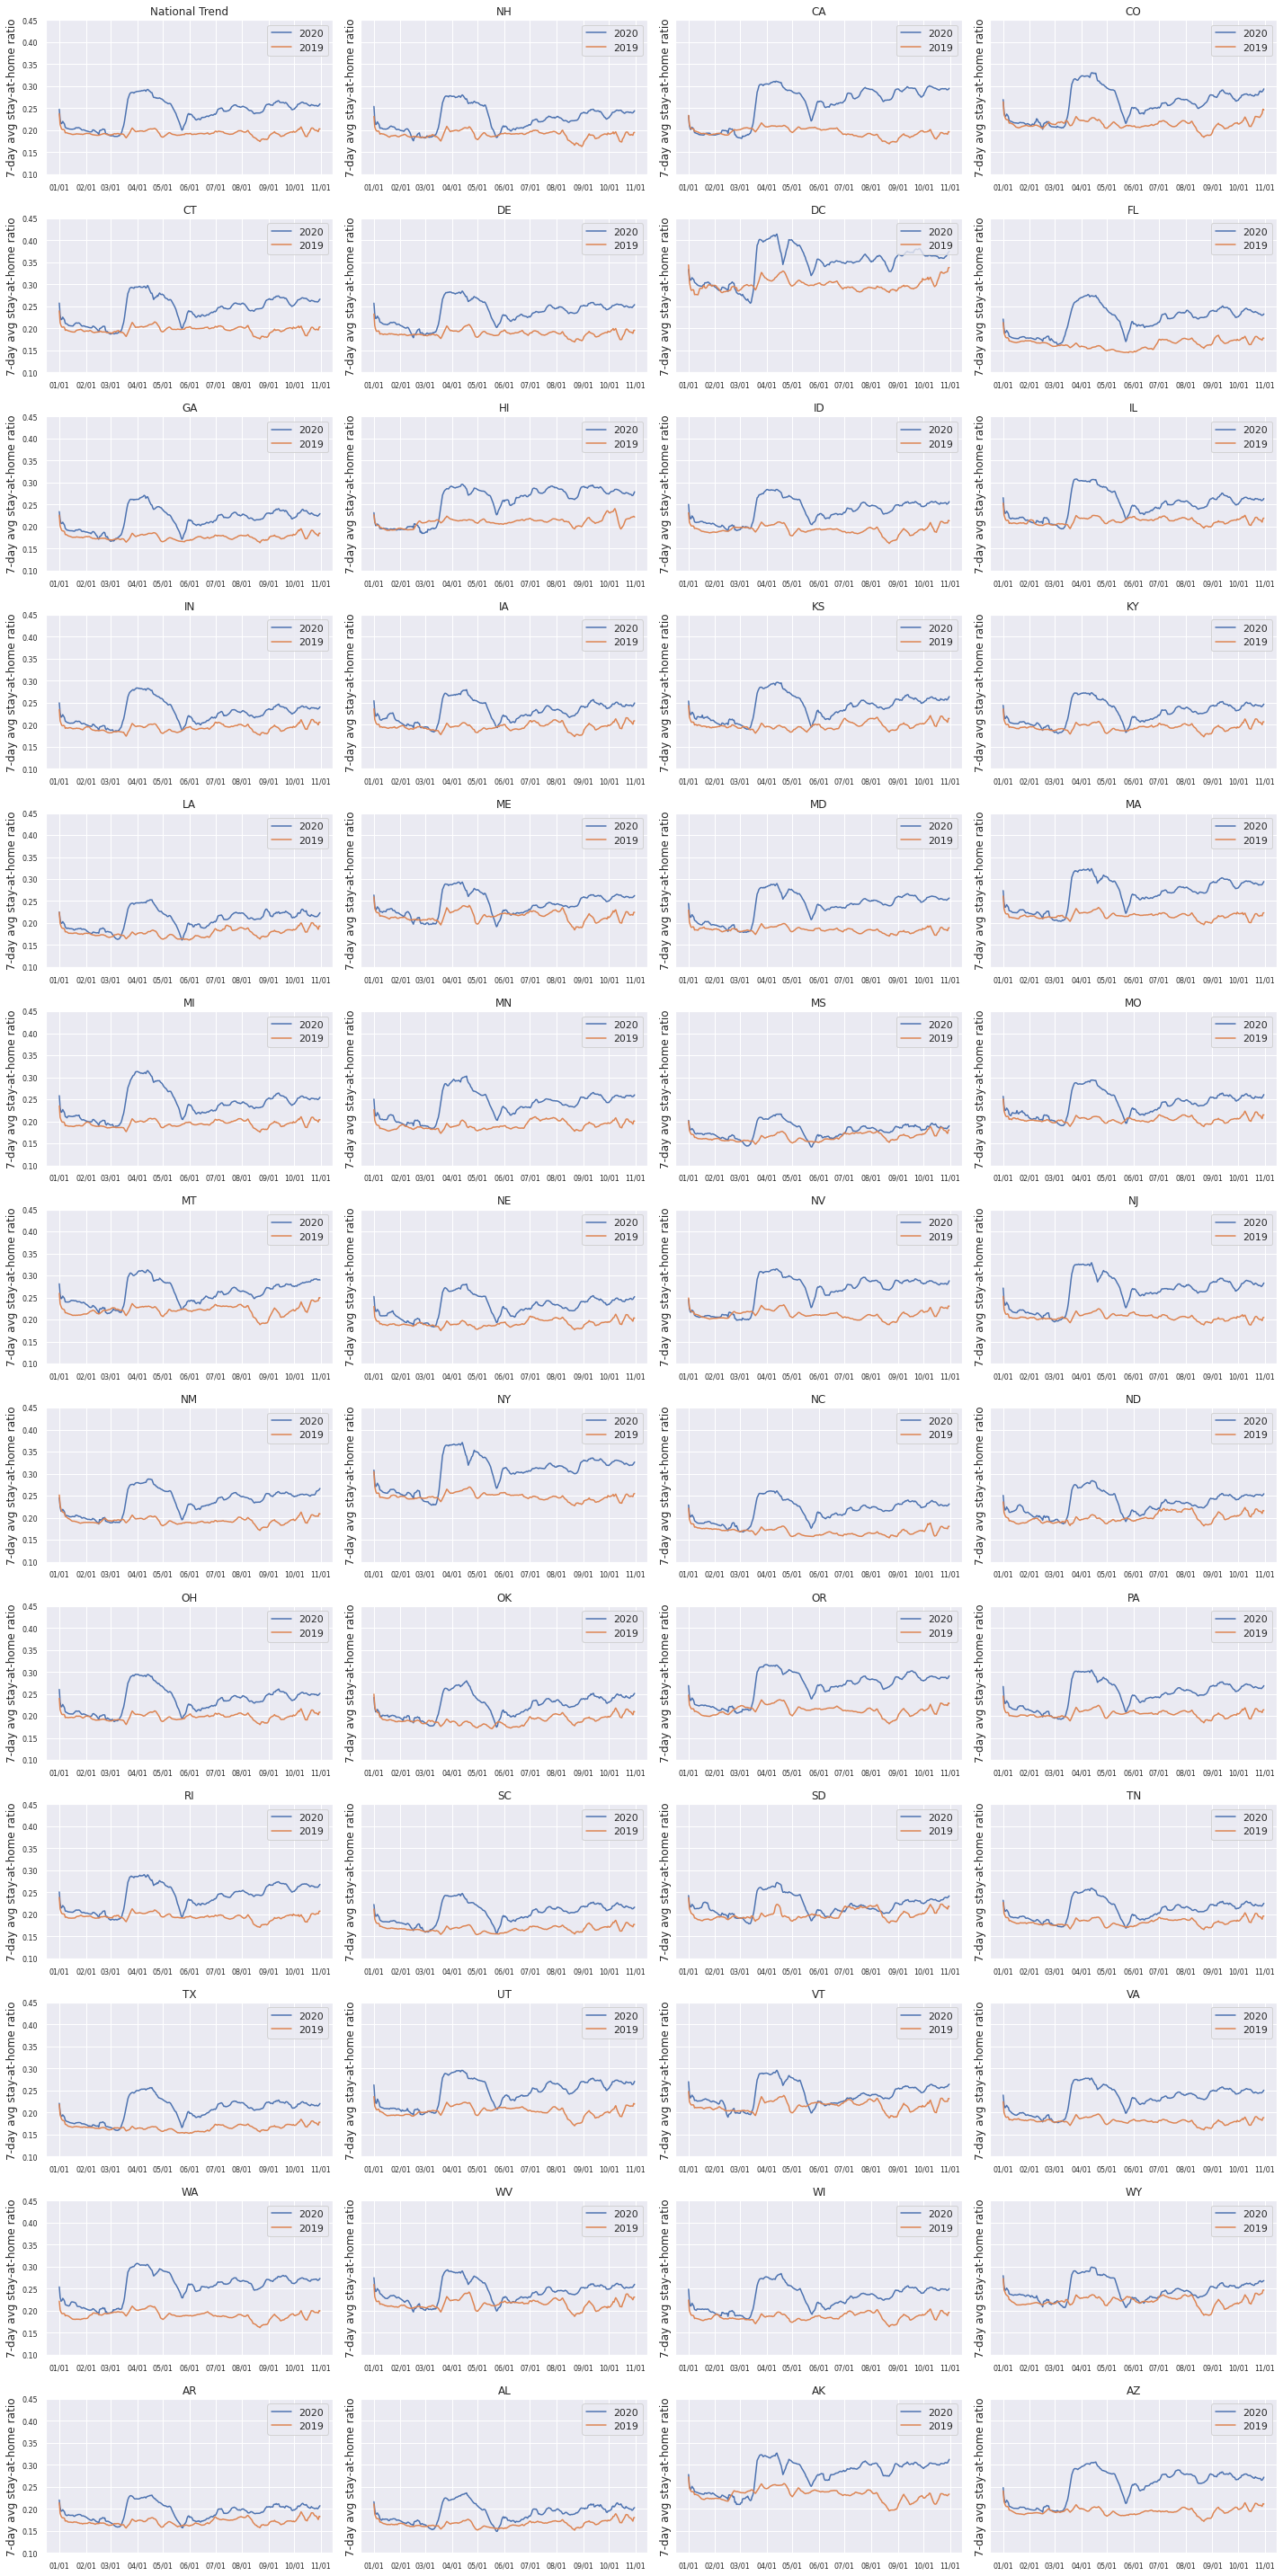

In [ ]:
# Time-series visualization for the US and each state

converted_dates = list(map(datetime.datetime.strptime, visual_data["national_2020"]["date"].values, len(visual_data["national_2020"]["date"].values)*['%Y-%m-%d']))

fig, axs = plt.subplots(13, 4, figsize = (20,40),sharey='row')
i = 0

for ax in axs.ravel():
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.tick_params(axis='both', which='major', labelsize=8)
    if i == 0:
        # plot national trend
        cur_df = visual_data["national_2020"]
        prev_df = visual_data["national_2019"]
        ax.set_title("National Trend")
    else:
        cur_df = cur_state[cur_state["state_code"] == state_names[i-1]]
        prev_df = prev_state[prev_state["state_code"] == state_names[i-1]]
        ax.set_title("%s"%(str(state_names[i-1])))

    ax.plot(converted_dates, cur_df["MA_7"], label = '2020')
    ax.plot(converted_dates, prev_df["MA_7"], label = '2019')
    ax.legend(loc = "upper right")
    ax.set_ylabel("7-day avg stay-at-home ratio")
    ax.set_ylim(0.1,0.45)
      
    i += 1
     
plt.tight_layout()
fig.savefig(path+"graphs/avg SAT ratio for states 2 years.png", dpi = 200)

In [ ]:
# Change fips from float to string
data_all["county_2020"]['county_fips'] = data_all["county_2020"]['county_fips'].apply(lambda x: str(int(x)).zfill(5))
data_all["county_2019"]['county_fips'] = data_all["county_2019"]['county_fips'].apply(lambda x: str(int(x)).zfill(5))

In [ ]:
# Calculate ratio of different types of trips
dist_agg = {}
for data_name in data_names:
    df = data_all[data_name] 
    df["trip_ratio"] = df["trips"]/df["pop"]
    df["short_trips"] = df["trips_1"] + df["trips_1_3"] + df["trips_3_5"] + df["trips_5_10"]
    df["med_trips"] = df["trips_10_25"] + df["trips_25_50"] + df["trips_25_50"] 
    df["long_trips"] = + df["trips_50_100"] + df["trips_100_250"] + df["trips_250_500"] + df["trips_500"] 

    df["short_trip_ratio"] = df["short_trips"]/df["trips"]
    df["med_trip_ratio"] = df["med_trips"]/df["trips"]
    df["long_trip_ratio"] = df["long_trips"]/df["trips"]

    dist_agg[data_name] = df[['date', 'state_fips', 'state_code', 
                              'county_fips', 'county',
                              'pop_stay_at_home', 'pop_not_stay_at_home', 
                              'trip_ratio',"short_trip_ratio",
                              "med_trip_ratio", "long_trip_ratio",
                              "only_date", "weekday",
                              "avg_stay_at_home_ratio","MA_7"]]


In [ ]:
# Calculate average statistics for each county
county_daily_avg = dist_agg["county_2020"].groupby(by = ["county_fips"], as_index = False).mean()
county_daily_avg.head(1)

,county_fips,state_fips,pop_stay_at_home,pop_not_stay_at_home,trip_ratio,short_trip_ratio,med_trip_ratio,long_trip_ratio,weekday,avg_stay_at_home_ratio,MA_7
0,01001,1.0,9740.433657,45860.566343,3.144182,0.741289,0.275752,0.027284,2.996764,0.175185,0.175019


In [ ]:
# avereage number of trips taken by everyone daily
fig = px.choropleth(county_daily_avg, 
                    geojson=counties, 
                    color_continuous_scale="Spectral",
                    locations='county_fips', color='short_trip_ratio',
                    range_color=(np.min(county_daily_avg["short_trip_ratio"]), np.max(county_daily_avg["short_trip_ratio"])),
                    scope="usa",
                    #labels={'unemp':'unemployment rate'}
                    )
fig.update_layout(title_text = 'Average Proportion of Short Trips in Total Trips ', title_x=0.5,)
fig.write_image(path+'graphs/short_trip_ratio.png',  format = "png", scale=2, engine="kaleido")

In [ ]:
# average ratio of long trips for everyone in the county
fig = px.choropleth(county_daily_avg, 
                    geojson=counties, 
                    color_continuous_scale="balance",
                    locations='county_fips', color='trip_ratio',
                    range_color=(np.min(county_daily_avg["trip_ratio"]), np.max(county_daily_avg["trip_ratio"])),
                    scope="usa",
                    #labels={'unemp':'unemployment rate'}
                    )
fig.update_layout(title_text = 'Daily Num of Trips per Person',title_x=0.5)
fig.write_image(path+'graphs/trip_ratio.png',  format = "png", scale=2, engine="kaleido")

In [ ]:
# average ratio of long trips for everyone in the county
fig = px.choropleth(county_daily_avg, 
                    geojson=counties, 
                    color_continuous_scale="Spectral",
                    locations='county_fips', color='avg_stay_at_home_ratio',
                    range_color=(np.min(county_daily_avg["avg_stay_at_home_ratio"]), np.max(county_daily_avg["avg_stay_at_home_ratio"])),
                    scope="usa",
                    #labels={'unemp':'unemployment rate'}
                    )
fig.update_layout(title_text = 'Average Stay at Home Ratio', title_x=0.5)
fig.write_image(path+'graphs/avg_stay_at_home_ratio.png',  format = "png", scale=2, engine="kaleido")

# 3. Policy Data 

## a. From KFF

In [ ]:
## date range
start = datetime.datetime.strptime("2020-06-04", "%Y-%m-%d")
end = datetime.datetime.strptime("2020-11-14", "%Y-%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

In [ ]:
np.random.seed(109)
df_dict = {}
filename = "_Social_Distancing.csv"

for d in date_generated:
    date = str(d.strftime("%Y-%m-%d"))
    try:
        df_dict[date] = pd.read_csv(path+'data/policy_data/'+str(date)+filename,skiprows=[1,2])
        df_dict[date].rename(columns={ df_dict[date].columns[0]: "Location" }, inplace = True)
    except:
        pass

In [ ]:
curr_df = df_dict['2020-11-13']
print(curr_df.shape)
curr_df.head(1)

(51, 10)


,Location,Status of Reopening,Stay at Home Order,Mandatory Quarantine for Travelers,Non-Essential Business Closures,Large Gatherings Ban,Restaurant Limits,Bar Closures,Face Covering Requirement,Emergency Declaration
0,Alabama,Paused,Lifted,-,All Non-Essential Businesses Permitted to Reop...,Lifted,Reopened to Dine-in Service,Reopened,Required for General Public,Yes


In [ ]:
quarantine_df_test = curr_df[["Location","Mandatory Quarantine for Travelers"]]
quarantine_df_test.head(1)

,Location,Mandatory Quarantine for Travelers
0,Alabama,-


In [ ]:
quarantine = {}
quarantine_df = quarantine_df_test[["Location"]]
for d in date_generated:
    date = str(d.strftime("%Y-%m-%d"))
    try:
        quarantine[date] = df_dict[date][["Location","Mandatory Quarantine for Travelers"]]
        quarantine_df[date] = df_dict[date]["Mandatory Quarantine for Travelers"]
    except:
        pass

In [ ]:
# quarantine['2020-11-13']["Mandatory Quarantine for Travelers"].value_counts()
quarantine['2020-11-13']["Mandatory Quarantine for Travelers"] = quarantine['2020-11-13']["Mandatory Quarantine for Travelers"].replace("-","Nothing")

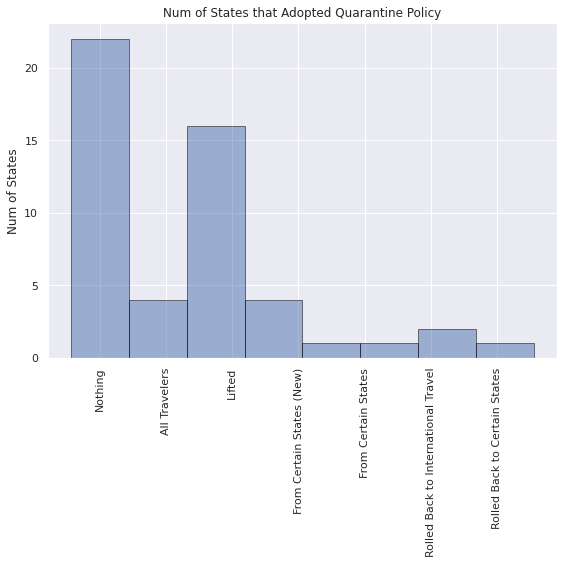

In [ ]:
fig = plt.figure(figsize = (8,8))
plt.hist(quarantine['2020-11-13']["Mandatory Quarantine for Travelers"], 
         align = "left", alpha=0.5, histtype='bar', ec='black',bins = 8)
plt.xticks(rotation=90)
plt.ylabel("Num of States")
plt.title("Num of States that Adopted Quarantine Policy")
plt.tight_layout()
plt.savefig(path+"graphs/Num of States that Adopted Quarantine Policy.png", dpi = 100)

In [ ]:
quarantine_df.head()

## b. From CovidVis
https://github.com/covidvis/covid19-vis

In [ ]:
# Import fisp file by Kieran Healy (@kjhealy) from github 
# To match state name with state code
state_name_code_path = "https://raw.githubusercontent.com/kjhealy/fips-codes/master/state_fips_master.csv"
state_name_code = pd.read_csv(state_name_code_path)
state_name_code.head()

In [ ]:
policy_df = pd.read_csv(path+"data/policy_data/quarantine-activity-US-Apr16-long.csv")
print(policy_df.shape)
print(policy_df.columns)

In [ ]:
policies = ['Travel Restrictions',
       'Shelter-in-place Order', 'Gathering Limitations',
       'Banning Gatherings of a Certain Size', 'K-12 School Closure',
       'Bar and Dine-in Restaurant Closure',
       'Non-essential Businesses Closure']

In [ ]:
policy_state_dfs = []
for policy in policies:
    cur_df = policy_df[~policy_df[policy].isna()].reset_index(drop = True)
    cur_df = cur_df[cur_df["Coverage.type"] == "State-wide"]
    cur_df = cur_df.merge(state_name_code, left_on = "State",
                    right_on="state_name", how = "inner")
    cur_df = cur_df[['State', 'Coverage.type', 'Coverage.location', 'Effective Date',
                 'State of Emergency Declaration','Details (if any)',
                'Reference links', 'Timestamp', 'population_size',
                'population_reference', 'state_name', 'state_abbr', 'fips', ]]

    
    policy_state_dfs.append(cur_df)
    print(policy, ":" ,len(cur_df))

In [ ]:
data_all["state_2020"].head()

In [ ]:
#Travel Restrictions
policy_state_dfs[0].head()

### Visualize policies' effects on stay-at-home ratio

In [ ]:

state_df = data_all["state_2020"]
state_names = state_df["state_code"].unique()
colors = ["red", "green","blue","pink", "orange","purple","brown"]
line_styles = [":",'-', '--', '-.',"dashdot","dotted","solid"]
converted_dates = list(map(datetime.datetime.strptime, data_all["national_2020"]["date"].values, len(data_all["national_2020"]["date"].values)*['%Y-%m-%d']))

fig, axs = plt.subplots(13, 4, figsize = (30,40),sharey='row')
i = 0
for ax in axs.ravel():
    if i == len(state_names):
        break

    cur_state = state_names[i]
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    cur_df = state_df[state_df["state_code"] == cur_state]
    ax.set_title("%s"%(str(cur_state)))

    # ax.plot(dates, cur_df['avg_stay_at_home_ratio'], label = "daily")
    ax.plot(converted_dates, cur_df["MA_7"], label = 'stay-at-home ratio',color = "black")
    
    for k in range(len(policies)):
        policy = policies[k]
        policy_state_df = policy_state_dfs[k]
        policy_states = policy_state_df["state_abbr"].values
        if cur_state in policy_states:
            index_ = list(policy_states).index(cur_state)
            policy_date = datetime.datetime.strptime(policy_state_df["Effective Date"][index_]+"20","%m/%d/%Y")
            ax.axvline(x=policy_date, label = "%s"%(policy), color = colors[k], linestyle=line_styles[k])
        

    ax.legend(loc = "upper right")
    ax.set_ylabel("7-day avg stay-at-home ratio")
      
    i += 1

fig.delaxes(axs[12,3])
plt.tight_layout()
fig.savefig("graphs/policies_vs_SAT_ratio.png")

### Visualize policies' effects on daily new cases

In [ ]:
state_df = data_all["state_2020"]
state_names = state_df["state_code"].unique()
colors = ["red", "green","blue","pink", "orange","purple","brown"]
line_styles = [":",'-', '--', '-.',"dashdot","dotted","solid"]

fig, axs = plt.subplots(13, 4, figsize = (30,40),sharey='row')
i = 0
for ax in axs.ravel():
    if i == len(state_names):
        break

    cur_state = state_names[i]
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    ax.set_title("%s"%(str(cur_state)))

    # ax.plot(dates, cur_df['avg_stay_at_home_ratio'], label = "daily")
    ax.plot(case_state_date, case_state_num.iloc[i,:], color = "black")
    
    for k in range(len(policies)):
        policy = policies[k]
        policy_state_df = policy_state_dfs[k]
        policy_states = policy_state_df["state_abbr"].values
        if cur_state in policy_states:
            index_ = list(policy_states).index(cur_state)
            policy_date = datetime.datetime.strptime(policy_state_df["Effective Date"][index_]+"20","%m/%d/%Y")
            ax.axvline(x=policy_date, label = "%s"%(policy), color = colors[k], linestyle=line_styles[k])
        

    ax.legend(loc = "upper right")
    ax.set_ylabel("new covid-19 cases")
      
    i += 1

fig.delaxes(axs[12,3])
plt.tight_layout()
fig.savefig("graphs/policies_vs_new_cases.png")